# Tarea 6: Transformers aplicado a traducción y clasificación de textos
## Curso: Procesamiento de Lenguaje Natural (NLP)
## Maestría en Computación
## Instituto Tecnológico de Costa Rica (ITCR)

Medio de entrega:  TecDigital.

Entregables: Un archivo jupyter con los ejercicios resueltos.

Modo de trabajo: individual o en grupos de máximo dos personas.

**Elaborado por**:


*   Victoria Orozco Arias. Carnet $2022438528$
*   Esteban Villalobos Gómez. Carnet $9913628$

**Fecha de entrega:** 19/10/2024



# EJERCICIO 2

In [ ]:
pip install torch transformers scikit-learn matplotlib


In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
import requests
import nltk
import re
import time

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from urllib.parse import unquote
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Use GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Utilizando GPU")
else:
  device = torch.device("cpu")
  print("Utilizando CPU")

Utilizando GPU


In [ ]:
%rm tweets.csv

url = "https://raw.githubusercontent.com/evillag/nlp/refs/heads/main/tareas/t5/tweets.csv"
response = requests.get(url)

with open("tweets.csv", "wb") as f:
  f.write(response.content)

df = pd.read_csv('tweets.csv')
print(df.info())

# Limpieza de la columnas de texto

features = ['keyword', 'location', 'text']
for columna in features:
  df[columna] = df[columna].fillna('N/A')
  df[columna] = df[columna].apply(lambda x: unquote(x) if isinstance(x, str) else x)

df.sample(20)

rm: cannot remove 'tweets.csv': No such file or directory
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
7430,10628,wounded,USA,ABC News: Police Officer Wounded Suspect Dead ...,1
363,521,army,Mexico! ^_^,5 Seconds of Summer Is my pick for http://t.co...,0
11,17,N/A,N/A,Haha South Tampa is getting flooded hah- WAIT ...,1
5169,7372,obliterate,Dudetown,@Gargron good sir I did not wish to but now I ...,0
3639,5188,fatalities,N/A,Mortal Kombat X: All Fatalities On Meat Predat...,0
6237,8906,snowstorm,"Louisiana, USA",you're the snowstorm I'm purified. the darkest...,0
145,209,airplane accident,bangalore,#Horrible #Accident Man Died In Wings Airplane...,1
6269,8957,storm,N/A,Is it bad to say that I'm kinda afraid of stor...,1
2838,4083,displaced,N/A,Displaced Persons GN (2014 Image) #1-1ST NM ht...,0
340,487,armageddon,Kent,Lee does comedy: ÛÏ@LeeJasper: Working class ...,0


In [ ]:
from transformers import BertTokenizer

df = df[['text', 'target']]

# Datos: entrenamiento (80%) y prueba (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Usar el tokenizador de BERT para convertir el texto a input_ids y attention_mask
# BERT requiere que el texto sea tokenizado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, tokenizer, max_len=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# Tokenizamos el texto del set de entrenamiento y prueba
train_encodings = tokenize_data(train_df['text'], tokenizer)
test_encodings = tokenize_data(test_df['text'], tokenizer)

# Convertir las etiquetas a tensores
train_labels = torch.tensor(train_df['target'].values)
test_labels = torch.tensor(test_df['target'].values)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        # se añade unacapa lineal que convierte las salidas de BERT en una predicción binaria
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        #se aplica una función sigmoide para convertir las salidas en probabilidades entre 0 y 1.
        self.sigmoid = nn.Sigmoid()

# define el paso siguiente del modelo
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

model = BERTClassifier()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.10401501544822114
Epoch 2, Loss: 0.0721310707120215
Epoch 3, Loss: 0.05993920739091141
Epoch 4, Loss: 0.06548882254981131
Epoch 5, Loss: 0.048769421707576
Epoch 6, Loss: 0.03996178435908479
Epoch 7, Loss: 0.04462804461319398
Epoch 8, Loss: 0.03969031942166813


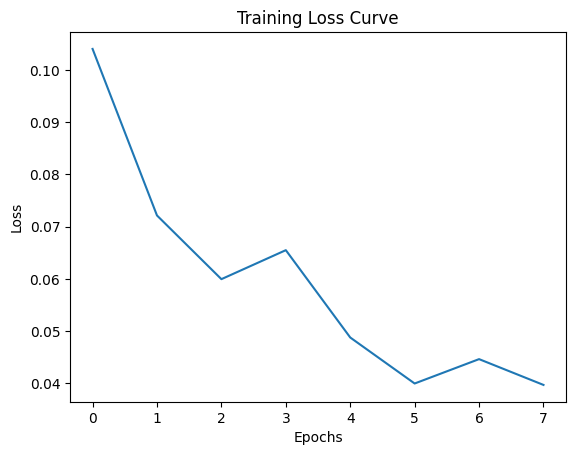

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Crear datasets y dataloaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Definir optimizador y función de pérdida
optimizer = AdamW(model.parameters(), lr=2e-5)  #optimizador que se usa comúnmente en modelos de lenguaje como BERT.
criterion = nn.BCELoss() #función de pérdida binaria (Binary Cross-Entropy) usada para problemas de clasificación binaria.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función de entrenamiento
def train(model, train_loader, criterion, optimizer, epochs=8):
    model.train()
    loss_values = []

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward() # para calcular los gradientes
            optimizer.step() # actualizar pesos
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

    return loss_values

# Entrenar el modelo
loss_values = train(model, train_loader, criterion, optimizer)

# Graficar la pérdida durante el entrenamiento
plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask).squeeze()
            preds = (outputs > 0.5).int()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    # Calcular la precisión, recall, f1-score y accuracy usando Scikit-learn
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['No Disaster', 'Disaster'])

    print(f"Accuracy on the test set: {accuracy:.4f}")
    print("\nClassification Report:\n", report)

# Evaluar el modelo en el conjunto de prueba
evaluate(model, test_loader)


Accuracy on the test set: 0.8260

Classification Report:
               precision    recall  f1-score   support

 No Disaster       0.81      0.90      0.86       874
    Disaster       0.85      0.72      0.78       649

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



Al incluir más epocs cuando se realiza el entrenamiento se puede observar una mejora en los resultados del modelo. La curva de pérdida muestra algunos puntos donde la pérdida aumenta, por ejemplo con en 3 y 6 presenta un aumento de pérdida sin embargo vuelve a disminuir en la siguiente.